Spatial Correlation between sea surface temperature anomaly and sea surface height anomaly
===========================
#### Authors: Dean Henze <dean.c.henze@jpl.nasa.gov> and Jinbo Wang <Jinbo.Wang@jpl.nasa.gov> 
*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*
<br/><br/>

Previous notebooks have covered the use of Dask and parallel computing applied to the type of task in the schematic below, where we wish to replicate a function identically over a set of files.

<img src="./schematic1.png" alt="sch1" width="500"/>

Further, a previous notebook explored applying this technique to the case of computing global maps of spatial correlation between sea surface temperature (SST) and sea surface height (SSH). For a recap of this analysis, see [link to notebook] and the description further below here. In the previous notebook, we applied Dask to this problem using a local cluster and `dask.delayed()`. In this notebook, we perform the same computations, but this time parallelize them using the third party software/package `Coiled`. In short `Coiled` will allow us to summon AWS VM's and create a distributed cluster out of them, all with a few lines of Python from within this notebook. *This means, once your Coiled account is set up, you can run this notebook entirely from your laptop while the computations will be run on a distributed cluster in AWS.* For more information on Coiled, setting up an account, and connecting it to an AWS account, see their website https://www.coiled.io. 


#### SST-SSH Correlation Analysis

This section briefly describes the analysis to which we will apply parallel computation. The analysis uses PO.DAAC hosted, gridded SSH and SST data sets:
* MEaSUREs gridded SSH Version 2205: 0.17° x 0.17° resolution, global map, one file per 5-days, https://doi.org/10.5067/SLREF-CDRV3
* GHRSST Level 4 MW_OI Global Foundation SST, V5.0: 0.25° x 0.25° resolution, global map, daily files, https://doi.org/10.5067/GHMWO-4FR05

The time period of overlap between these data sets is 1998 – 2020, with 1808 days in total overlapping. For each pair SST, SSH files on these days, compute a map of spatial correlation between them, where the following method is used at each gridpoint:

<img src="./schematic_sst-ssh_corr.png" alt="sch_sst-ssh-corr" width="1000"/>



In [1]:
# Built in packages
import time
import sys
import os

# Math / science packages
import xarray as xr
import numpy as np
from scipy.optimize import leastsq

# Plotting packages
from matplotlib import pylab as plt

# Cloud / parallel computing packages
import earthaccess
import coiled

In [2]:
xr.set_options( # display options for xarray objects in this notebook
    display_expand_attrs=False,
    display_expand_coords=False,
    display_expand_data=True,
    )

# Define functions

The main function implemented is `spatial_corrmap()`, which will return the map of correlations as a 2D array. The other functions written below are called by `spatial_corrmap()`.  

In [3]:
def load_sst_ssh(gran_ssh, gran_sst):
    """
    Return SLA and SST variables for a single file each of the 
    SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and MW_OI-REMSS-L4-GLOB-v5.0 
    collections, respectively, returned as xarray.DataArray's. Input args are granule info 
    (earthaccess.results.DataGranule object's) for each collection.  
    """
    earthaccess.login(strategy="environment") # Confirm credentials are current
    
    # Get SLA and SST variables, loaded fully into local memory:
    ssh = xr.load_dataset(earthaccess.open([gran_ssh], provider='POCLOUD')[0])['SLA'][0,...]
    sst = xr.load_dataset(earthaccess.open([gran_sst], provider='POCLOUD')[0])['analysed_sst'][0,...]

    return ssh, sst

In [4]:
def spatialcorr(x, y, p1, p2):
    """
    Correlation between two 2D variables p1(x, y), p2(x, y), over the domain (x, y). Correlation is 
    computed between the anomalies of p1, p2, where anomalies for each variables are the deviations from 
    respective linear 2D surface fits.
    """
    # Compute anomalies:
    ssha, _ = anomalies_2Dsurf(x, y, p1, kind='linear')
    ssta, _ = anomalies_2Dsurf(x, y, p2, kind='linear')
    
    # Compute correlation coefficient:
    a, b = ssta.flatten(), ssha.flatten()
    if ( np.nansum(abs(a))==0 ) or ( np.nansum(abs(b))==0 ): # There are some cases where all anomalies for one var are 0.
        # In this case, correlation should be 0. Numpy will compute this correctly, but will also throw a lot of warnings.
        # Get around this by manually appending 0 instead.
        return 0
    else:
        return np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))


def anomalies_2Dsurf(x, y, p, kind='linear'):
    """
    Get anomalies for a variable over a 2D map. Done by fitting a 2D surface 
    to the data (scipy) and taking the anomaly as the difference between each data point 
    and the surface. Surface can either be a linear or quadratic function.
    
    Inputs
    ------
    x, y: 1D array-like.
        Independent vars (likely the lon, lat coordinates).
    p: 2D array-like, of shape (len(y), len(x)).
        Dependent variable. 2D surface fit will be to p(x, y).
    kind: str
        Functional form of the fit surface. Either 'linear' (default) or 'quadratic'.
    
    Returns
    ------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).
    """
    # Depending on fit fxn chosen, define functions to output a 2D surface (surface()) 
    # and the difference between 2D data and the computed surface (err()).
    if kind=='linear':
        def err(c,x0,y0,p): # Takes independent/dependent vars and poly coefficients
            a,b,c=c
            return p - (a + b*x0 + c*y0 )

        def surface(c,x0,y0): # Takes independent vars and poly coefficients
            a,b,c=c
            return a + b*x0 + c*y0

    if kind=='quadratic':
        def err(c,x0,y0,p):
            a,b,c,d,e,f=c
            return p - (a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0)
        
        def surface(c,x0,y0):
            a,b,c,d,e,f=c
            return a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0


    # Prep arrays and remove NAN's:
    xx, yy = np.meshgrid(x, y)
    xf=xx.flatten()
    yf=yy.flatten()
    pf=p.flatten()

    msk=~np.isnan(pf)
    pf=pf[msk]
    xf=xf[msk]
    yf=yf[msk]

    
    # Initial values of polynomial coefficients to start fitting algorithm off with:
    dpdx=(pf.max()-pf.min())/(xf.max()-xf.min())
    dpdy=(pf.max()-pf.min())/(yf.max()-yf.min())
    if kind=='linear':
        c = [pf.mean(),dpdx,dpdy]
    if kind=='quadratic':
        c = [pf.mean(),dpdx,dpdy,1e-22,1e-22,1e-22]


    # Fit and compute anomalies:
    coef = leastsq(err,c,args=(xf,yf,pf))[0]
    vm = surface(coef, xx, yy) # mean surface
    va = p - vm # anomalies
    return va, vm

In [5]:
def spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=None, lons=None, f_notnull=0.5):
    """
    Get a 2D map of SSH-SST spatial correlation coefficients, for one each of the 
    SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and MW_OI-REMSS-L4-GLOB-v5.0 collections. 
    At each gridpoint, the spatial correlation is computed over a lat, lon window of size 
    2*lat_halfwin x 2*lon_halfwin. Correlation is computed from the SSH, SST anomalies, which are computed 
    in turn as the deviations from a fitted 2D surface over the window.
    
    Inputs
    ------
    grans: 2-tuple of earthaccess.results.DataGranule objects
        Granule info for the SSH, SST files (in that order). These objects contain https and S3 locations.
    lat_halfwin, lon_halfwin: floats
        Half window size in degrees for latitude and longitude dimensions, respectively.
    lats, lons: None or 1D array-like
        Latitude, longitude gridpoints at which to compute the correlations. 
        If None, will use the SSH grid.
    f_notnull: float between 0-1 (default = 0.5)
        Threshold fraction of non-NAN values in a window in order for the correlation to be computed,
        otherwise NAN is returned for that grid point. For edge cases, 'ghost' elements are counted as NAN.

    Returns
    ------
    coef: 2D numpy array
        Spatial correlation coefficients.
    
    lats, lons: 1D numpy arrays.
        Latitudes and longitudes creating the 2D grid that 'coef' was calculated on.
    """    
    # Load datafiles, convert SST longitude to (0,360), and interpolate SST to SSH grid:    
    ssh, sst = load_sst_ssh(*grans)
    sst = sst.roll(lon=len(sst['lon'])//2)
    sst['lon'] = sst['lon']+180
    sst = sst.interp(lon=ssh['Longitude'], lat=ssh['Latitude'])

    
    # Compute windows size and threshold number of non-nan points:
    dlat = (ssh['Latitude'][1]-ssh['Latitude'][0]).item()
    dlon = (ssh['Longitude'][1]-ssh['Longitude'][0]).item()
    nx_win = 2*round(lon_halfwin/dlon)
    ny_win = 2*round(lat_halfwin/dlat)
    n_thresh = nx_win*ny_win*f_notnull


    # Some prep work for efficient identification of windows where number of non-nan's < threshold:
        # Map of booleans for sst*ssh==np.nan
    notnul = (sst*ssh).notnull() 
        # Combine map and sst, ssh data into single Dataset for more efficient indexing:
    notnul = notnul.rename("notnul") # Needs a name to merge
    mergeddata = xr.merge([ssh, sst, notnul], compat="equals")
     

    # Compute spatial correlations over whole map:
    coef = []
    
    if lats is None:
        lats = ssh['Latitude'].data
        lons = ssh['Longitude'].data
    
    for lat_cen in lats:
        for lon_cen in lons:

            # Create window for both sst and ssh with xr.sel:
            lat_bottom = lat_cen - lat_halfwin
            lat_top = lat_cen + lat_halfwin
            lon_left = lon_cen - lon_halfwin
            lon_right = lon_cen + lon_halfwin
            data_win = mergeddata.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
    
            # If number of non-nan values in window is less than threshold 
            # value, append np.nan, else compute correlation coefficient:
            n_notnul = data_win["notnul"].sum().item()
            if n_notnul < n_thresh:
                coef.append(np.nan)
            else:
                c = spatialcorr(data_win['Longitude'], data_win['Latitude'], data_win['SLA'].data, data_win['analysed_sst'].data)
                coef.append(c)
    
    return np.array(coef).reshape((len(lats), len(lons))), np.array(lats), np.array(lons)

# Get all matching pairs of SSH, SST granules for 2018

In [6]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [7]:
## Granule info for all files in 2018:
grans_ssh = earthaccess.search_data(
    short_name="SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205",
    temporal=("2018-01-01", "2018-12-31"),
    )
grans_sst = earthaccess.search_data(
    short_name="MW_OI-REMSS-L4-GLOB-v5.0",
    temporal=("2018-01-01", "2018-12-31"),
    )

Granules found: 73
Granules found: 365


In [8]:
## File coverage dates extracted from granule info:
dates_ssh = [g['umm']['GranuleUR'].split('_')[-1][:8] for g in grans_ssh]
print(dates_ssh[:10])
dates_sst = [g['umm']['GranuleUR'][:8] for g in grans_sst]
print(dates_sst[:10])

['20180102', '20180107', '20180112', '20180117', '20180122', '20180127', '20180201', '20180206', '20180211', '20180216']
['20180101', '20180102', '20180103', '20180104', '20180105', '20180106', '20180107', '20180108', '20180109', '20180110']


In [9]:
## Granule info for matching pairs of files stored in 'grans_ssh_analyze' and 'grans_sst_analyze':
grans_ssh_analyze = []
grans_sst_analyze = []
for j in range(len(dates_ssh)):
    if dates_ssh[j] in dates_sst:
        grans_ssh_analyze.append(grans_ssh[j])
        grans_sst_analyze.append(grans_sst[dates_sst.index(dates_ssh[j])])

# Test the computation on a pair of files, output on a coarse resolution grid

In [13]:
# Compute spatial correlation map for 2 degree x 2 degree resolution and time it:
t1 = time.time()

lats = np.arange(-80, 80, 2)
lons = np.arange(0, 359, 2)
coef, lats, lons = spatial_corrmap((grans_ssh_analyze[0], grans_sst_analyze[0]), 3, 3, lats=lats, lons=lons, f_notnull=0.5)

t2 = time.time()
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds.")

Opening 1 granules, approx size: 0.01 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Opening 1 granules, approx size: 0.0 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Total computation time = 25.19 seconds.


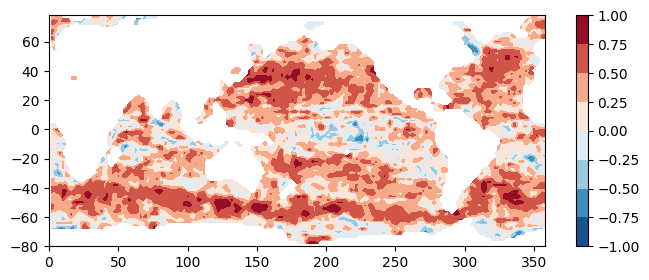

In [14]:
plt.figure(figsize=(8,3))
plt.contourf(lons, lats, coef, cmap='RdBu_r')
plt.colorbar()

### Estimation of computation time for higher resolution output and more files

The computation for one file computed on a 2 x 2 degree grid takes:

In [15]:
print(str(comptime) + " seconds.")

25.19 seconds.


then assuming linear scaling, processing one file at 0.5 x 0.5 degree resolution would take:

In [16]:
eta_fullres_seconds = comptime*(2/0.5)*(2/0.5)
eta_fullres_minutes = round(eta_fullres_seconds/60)
print(str(eta_fullres_minutes) + " minutes.")

7 minutes.


and for the record over all of 2018 would take:

In [17]:
eta_allfiles_hrs = round( (len(grans_ssh)*eta_fullres_minutes)/60, 1 )
eta_allfiles_days = round(eta_allfiles_hrs/24, 2)
print(str(len(grans_ssh)) + " granules for 2018.")
print(str(eta_allfiles_hrs) + " hours = " + str(eta_allfiles_days) + " days.")

73 granules for 2018.
8.5 hours = 0.35 days.


# Parallelize the computation with Coiled Functions
The previous section showed that analyzing a year's worth of data at 0.5 x 0.5 degree output resolution would take 7-8 hrs (at least at the time this notebook was written, perhaps it will be shorter in the future?). In this section, we use Coiled to parallelize this computation to take about 10 minutes and cost ~$1 (again, at the time this was written!).

Recall that our task is to replicate and apply our function to all the files. This type of parallelization can be accomplished with a call to `coiled.function()`. Alright let's go!

In [10]:
def corrmap_toda(grans, lat_halfwin=3, lon_halfwin=3, lats=None, lons=None, f_notnull=0.5):
    """
    Calls spatial_corrmap() and collects output into an Xarray DataArray. Returns this array along with date
    """
    coef, lats, lons = spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=lats, lons=lons, f_notnull=0.5)
    return xr.DataArray(data=coef, dims=["lat", "lon"], coords=dict(lon=lons, lat=lats), name='corr_ssh_sst')

In [12]:
# All output will be saved to this local directory:
dir_results = "results/"
os.makedirs(dir_results, exist_ok=True)

In [13]:
# Latitudes, longitudes of output grid at 0.5 degree resolution:
lats = np.arange(-80, 80, 0.5)
lons = np.arange(0, 359, 0.5)

In [14]:
## -----------------------------
## Perform and time computations
## -----------------------------

t1 = time.time()


# Wrap function in a Coiled function. Here is where we make cluster specifications like
# VM type, and that we want Earthdata Login credentials passed to each VM:
corrmap_toda_parallel = coiled.function(
    region="us-west-2", spot_policy="on-demand", vm_type="m6i.large", 
    environ=earthaccess.auth_environ()
    )(corrmap_toda)

# Optional: manually scale workers:
corrmap_toda_parallel.cluster.scale(73)

# Begin computations:
results = corrmap_toda_parallel.map(
    list(zip(grans_ssh_analyze, grans_sst_analyze)),
    lat_halfwin=3, lon_halfwin=3, lats=lats, lons=lons, f_notnull=0.5, 
    )

# Retreive the results from the cluster as they become available and save as .nc files locally:
for result_da, gran in zip(results, grans_ssh_analyze):
     date_gran = gran['umm']['GranuleUR'].split("_")[-1][:8] # get date from SSH UR to use in filename.
     fn_save = dir_results+"spatial-corr-map_ssh-sst_" + date_gran + ".nc" # filename to use
     result_da.to_netcdf(fn_save)

# Since we manually scaled up the cluster, we have to manually scale it back down if we want to stop using resources:
corrmap_toda_parallel.cluster.scale(1)


t2 = time.time()
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds = " + str(comptime/60) + " minutes.") 

Output()

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                                                     ╷                                            │
│   Package                                           │ Note                                       │
│ ╶───────────────────────────────────────────────────┼──────────────────────────────────────────╴ │
│   Babel                                             │ https://pypi.org/pypi                      │
│   Cartopy                                           │ https://pypi.org/pypi                      │
│   Deprecated                                        │ https://pypi.org/pypi                      │
│   Jinja2                                            │ https://pypi.org/pypi                      │
│   MarkupSafe                                        │ https://pypi.org/pypi                      │
│   Pillow                                            │ https://pypi.org/pypi                      │
│   PyNaCl                                            │ https://pypi.org/pypi                      │
│   PyYAML                                            │ https://pypi.org/pypi                      │
│   Pygments                                          │ https://pypi.org/pypi                      │
│   Send2Trash                                        │ https://pypi.org/pypi                      │
│   aiobotocore                                       │ https://pypi.org/pypi                      │
│   aiohttp                                           │ https://pypi.org/pypi                      │
│   aioitertools                                      │ https://pypi.org/pypi                      │
│   aiosignal                                         │ https://pypi.org/pypi                      │
│   anyio                                             │ https://pypi.org/pypi                      │
│   argon2-cffi                                       │ https://pypi.org/pypi                      │
│   argon2-cffi-bindings                              │ https://pypi.org/pypi                      │
│   arrow                                             │ https://pypi.org/pypi                      │
│   asttokens                                         │ https://pypi.org/pypi                      │
│   async-lru                                         │ https://pypi.org/pypi                      │
│   async-timeout                                     │ https://pypi.org/pypi                      │
│   attrs                                             │ https://pypi.org/pypi                      │
│   backcall                                          │ https://pypi.org/pypi                      │
│   backoff                                           │ https://pypi.org/pypi                      │
│   bcrypt                                            │ https://pypi.org/pypi                      │
│   beautifulsoup4                                    │ https://pypi.org/pypi                      │
│   bleach                                            │ https://pypi.org/pypi                      │
│   bokeh                                             │ https://pypi.org/pypi                      │
│   boto3                                             │ https://pypi.org/pypi                      │
│   botocore                                          │ https://pypi.org/pypi                      │
│   bounded-pool-executor                             │ https://pypi.org/pypi                      │
│   certifi                                           │ https://pypi.org/pypi                      │
│   cffi                                              │ https://pypi.org/pypi                      │
│   cftime                                            │ https://pypi.org/pypi                      │
│   charset-normalizer                                │ https://pypi.org/pypi                      │
│   click                                             │ https

Output()

2024-03-29 23:13:44,146 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=0 maximum=500


Total computation time = 516.55 seconds = 8.609166666666665 minutes.


In [15]:
corrmap_toda_parallel.cluster.shutdown()

2024-03-29 23:31:22,404 - distributed.deploy.adaptive_core - INFO - Adaptive stop
2024-03-29 23:31:22,596 - distributed.deploy.adaptive_core - INFO - Adaptive stop


## Open and plot results from one of the files

In [20]:
fns_results = [f for f in os.listdir(dir_results) if f.endswith("nc")]
testfile = xr.load_dataset(dir_results + fns_results[-1])
testfile

<xarray.Dataset>
Dimensions:       (lon: 718, lat: 320)
Coordinates: (2)
Data variables:
    corr_ssh_sst  (lat, lon) float64 nan nan nan nan ... -0.02682 nan nan

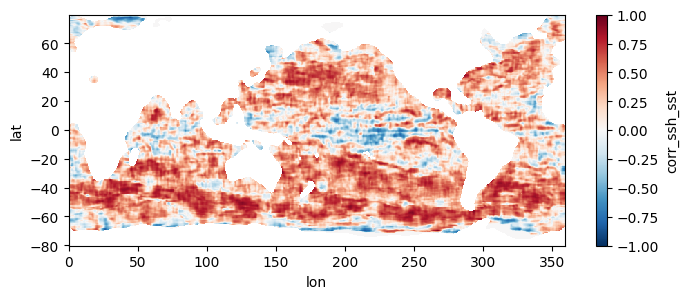

In [21]:
testfile["corr_ssh_sst"].plot(figsize=(8,3), vmin=-1, vmax=1, cmap='RdBu_r')

## Other options

1. Try the following lines of code to switch between manual and auto scaling of the cluster:

In [ ]:
## Try using the manual scaling:
#spatial_corrmap_coiled.cluster.scale(200)
#spatial_corrmap_coiled.cluster.adapt(minimum=X, maximum=Y)

2. Try options to run cluster while minimizing costs: 

In [ ]:
#spatial_corrmap_coiled = coiled.function(region="us-west-2", cpu=1, arm=True, spot_policy="spot_with_fallback", environ=earthaccess.auth_environ())(spatial_corrmap)